## Bayesian Forecasting with Markov Chain Monte Carlos


Bayesian statistics tries to use existing assumptions (priors) and observed evidence (likelihood) to update our view about a parameter

            p(θ|X) = p(X|θ) / p(θ)p(X)


p(θ|X) = Posterior distribution

p(θ) = Prior distribution

p(X|θ) = Likelihood distribution

p(X) = Marginal Likelihood/normalizing constant = =∫dθ∗p(X|θ∗)p(θ∗)

  

There are three approaches to determining the functions used in calculating the posterior distribution:

(1) Analytical solutions (in cases where the posterior and prior share the same form of distribution aka conjugate priors)

(2) Numerical integration

(3) Approximation through sampling (to include the Markov Chain Monte Carlo method)


In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
sns.set()

## Analytical Approach

This technqiue is feasible when the prior and posterior distributions are from the same distribution family which lends itself to a closed-form solution.

Informative vs Uninformative Priors
The posterior distribution depends on the prior and the data (likelihood distribution). As the amount of data becomes larges, the posterior distribution approximates the MLE. However, more informative priors (those with more peaked distribution) will require more data to shift than an uninfromative one (more flat distribution).

Increase the values of a and b below: does the MAP line move away or towards the MLE line?
Likewise, increase the value of n, what happens then to the lines?


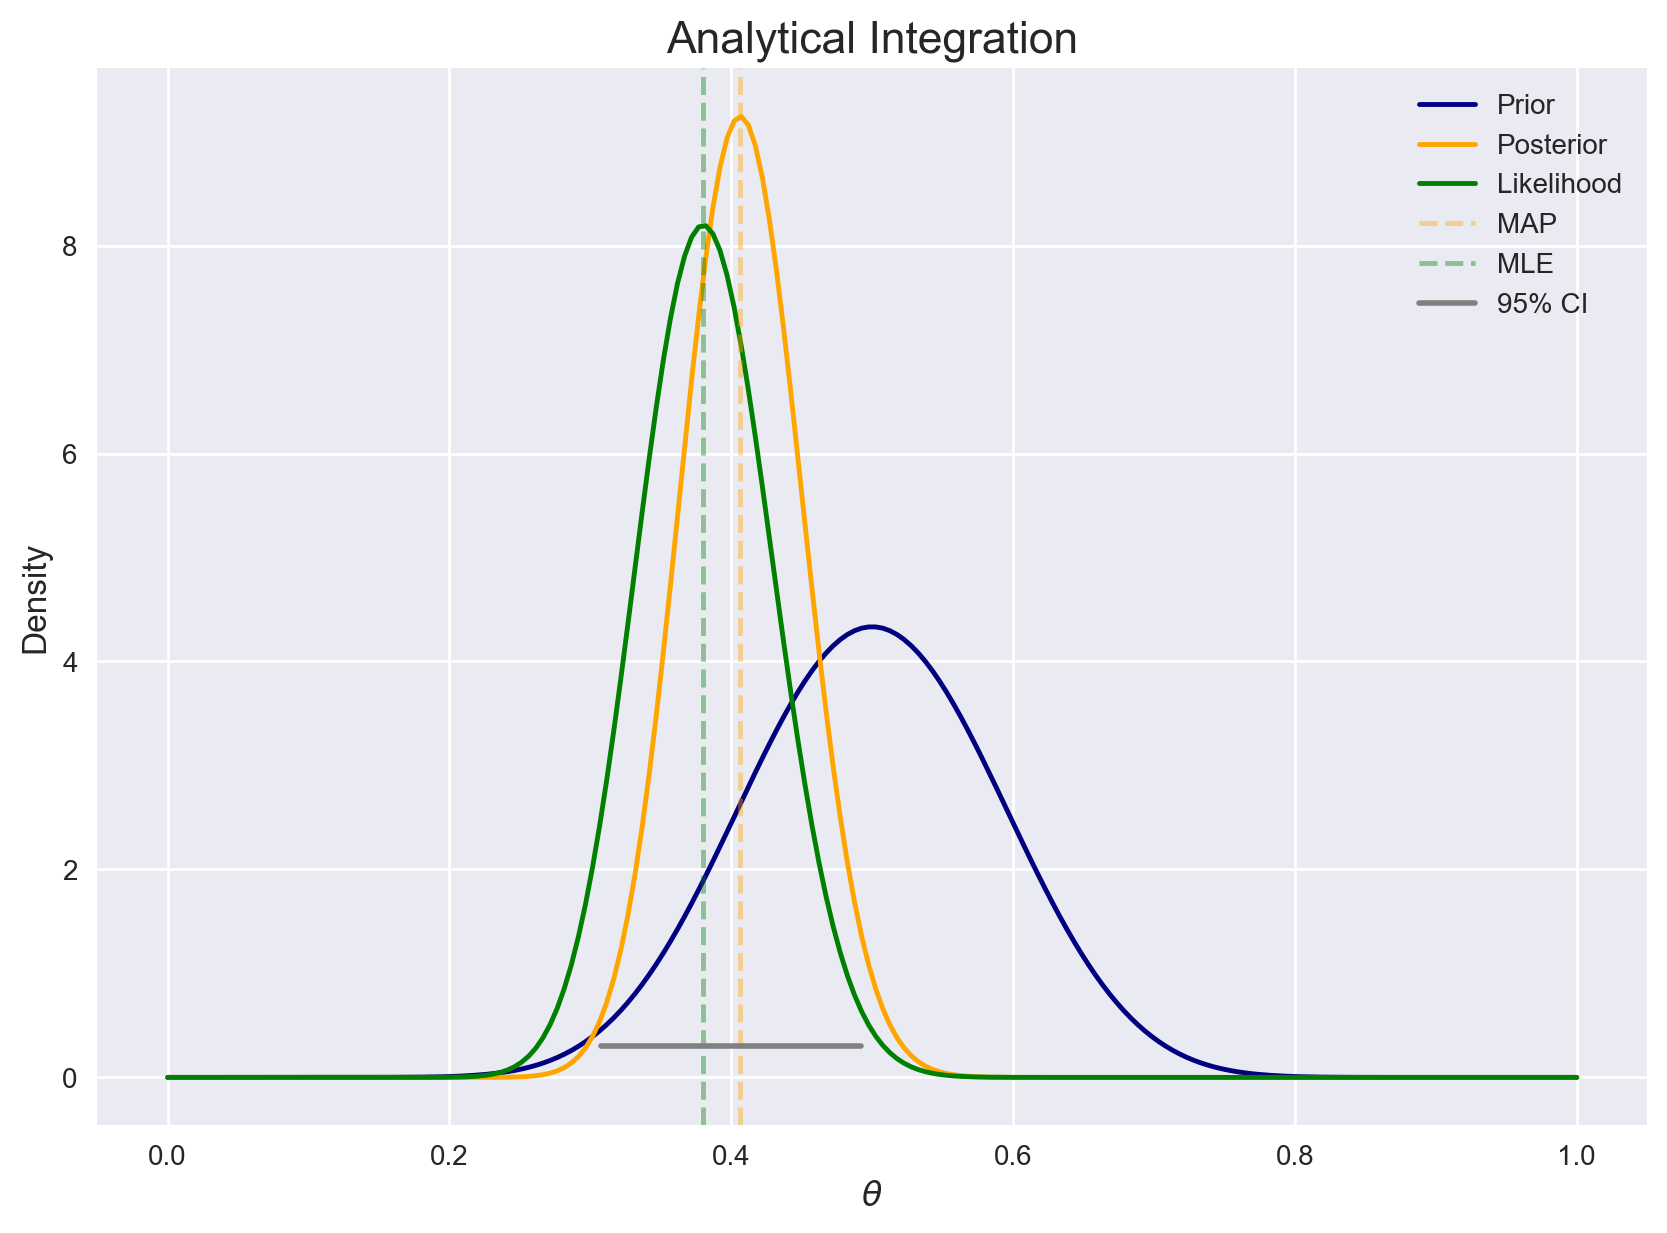

In [243]:
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':200})
plt.title("Analytical Integration", fontsize=16)


# likelihood distribution
# number of trials
n = 100
# probability of success
p = 0.38


s = int(n * p) # successful trials
#s = n * p # successful trials
rv = st.binom(n, p)
mu = rv.mean()

# prior distribution
a, b = 15,15
# exponents of the random variable in the beta pdf that control the shape of the distribution
dist_prior = st.beta(a, b)

# posterior distribution
dist_posterior = st.beta(s+a, n-s+b)

# confidence interval
mu_posterior = dist_posterior.mean()
sigma_posterior = dist_posterior.std()
ci = dist_posterior.interval(0.95) #, loc = mu_posterior, scale = sigma_posterior/(n**(1/2)))

thetas = np.linspace(0, 1, 200)
dist_likelihood = n*st.binom(n, thetas).pmf(s)


# Plot distributions
plt.plot(thetas, dist_prior.pdf(thetas), label='Prior', c='Navy')
plt.plot(thetas, dist_posterior.pdf(thetas), label='Posterior', c='orange')
plt.plot(thetas, dist_likelihood, label='Likelihood', c='Green')
plt.xlabel(r'$\theta$', fontsize=12)
plt.ylabel('Density', fontsize=12)

'''
Add MAP and MLE
MAP - maximum a posterior estimate is the mode of the posterior distribution
MLE - maximum likelihood estimate in Bayesian inference is the mode of the likelihood
'''
plt.axvline((s+a-1)/(n+a+b-2), c='Orange', linestyle='dashed', alpha=0.4, label='MAP') # maximum a posterior estimate = mode of the posterior
plt.axvline(mu/n, c='Green', linestyle='dashed', alpha=0.4, label='MLE') # 

# Add confidence interval
plt.axhline(0.3, ci[0], ci[1], c='Gray', linewidth=2, label='95% CI')

plt.legend()

## Markov Chain Monte Carlo - Samplers

There are three common variants of the MCMC: Metropolis-Hastings, Gibbs and slice sampling. All of the techniques aim to estimate the posterior distribution when a high-dimensional marginal likelihood makes it otherwise intractable. 

The MCMC method draws samples from a proposal distribution so that each draw depends only on the state of the previous draw, forming a Markov chain. After a number of iterations, the Markov chain of accepted draws will converge to the staionary distribution and we can find functions of the posterior distribution.

Below is rudimentary, raw implementation of the simplest to understand sample, the Metropolis-Hastings random walk algorithm.

In [195]:
def udf_in_target_dist(dist_likelihood, dist_prior, n, s, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return dist_likelihood(n, theta).pmf(s)*dist_prior.pdf(theta)

def udf_example_mcmc(n_iterations,n_trials,successes,a,b,sigma):
    '''
    Example implementation of the Metropolis Hastings Algorithm

    '''
    dist_likelihood = st.binom
    dist_prior = st.beta(a, b)

    n_accepted = 0
    theta = 0.1
    #n_iterations = 100
    samples = np.zeros(n_iterations+1)
    samples[0] = theta

    for i in range(n_iterations):
        theta_p = theta + st.norm(0, sigma).rvs()
        rho = min(1, udf_in_target_dist(dist_likelihood, dist_prior, n_trials, s, theta_p)
                  / udf_in_target_dist(dist_likelihood, dist_prior, n_trials, s, theta)
                 )
        u = np.random.uniform()
    
        if u < rho:
            n_accepted += 1
            theta = theta_p

        samples[i+1] = theta
    
    n_mcmc = int(len(samples)//2)
    #print("Efficiency = ", n_accepted/n_iterations)
    return n_mcmc, dist_prior, samples

In [209]:
results_mcmc_10000 = udf_example_mcmc(10000,100,38,15,15,.3)

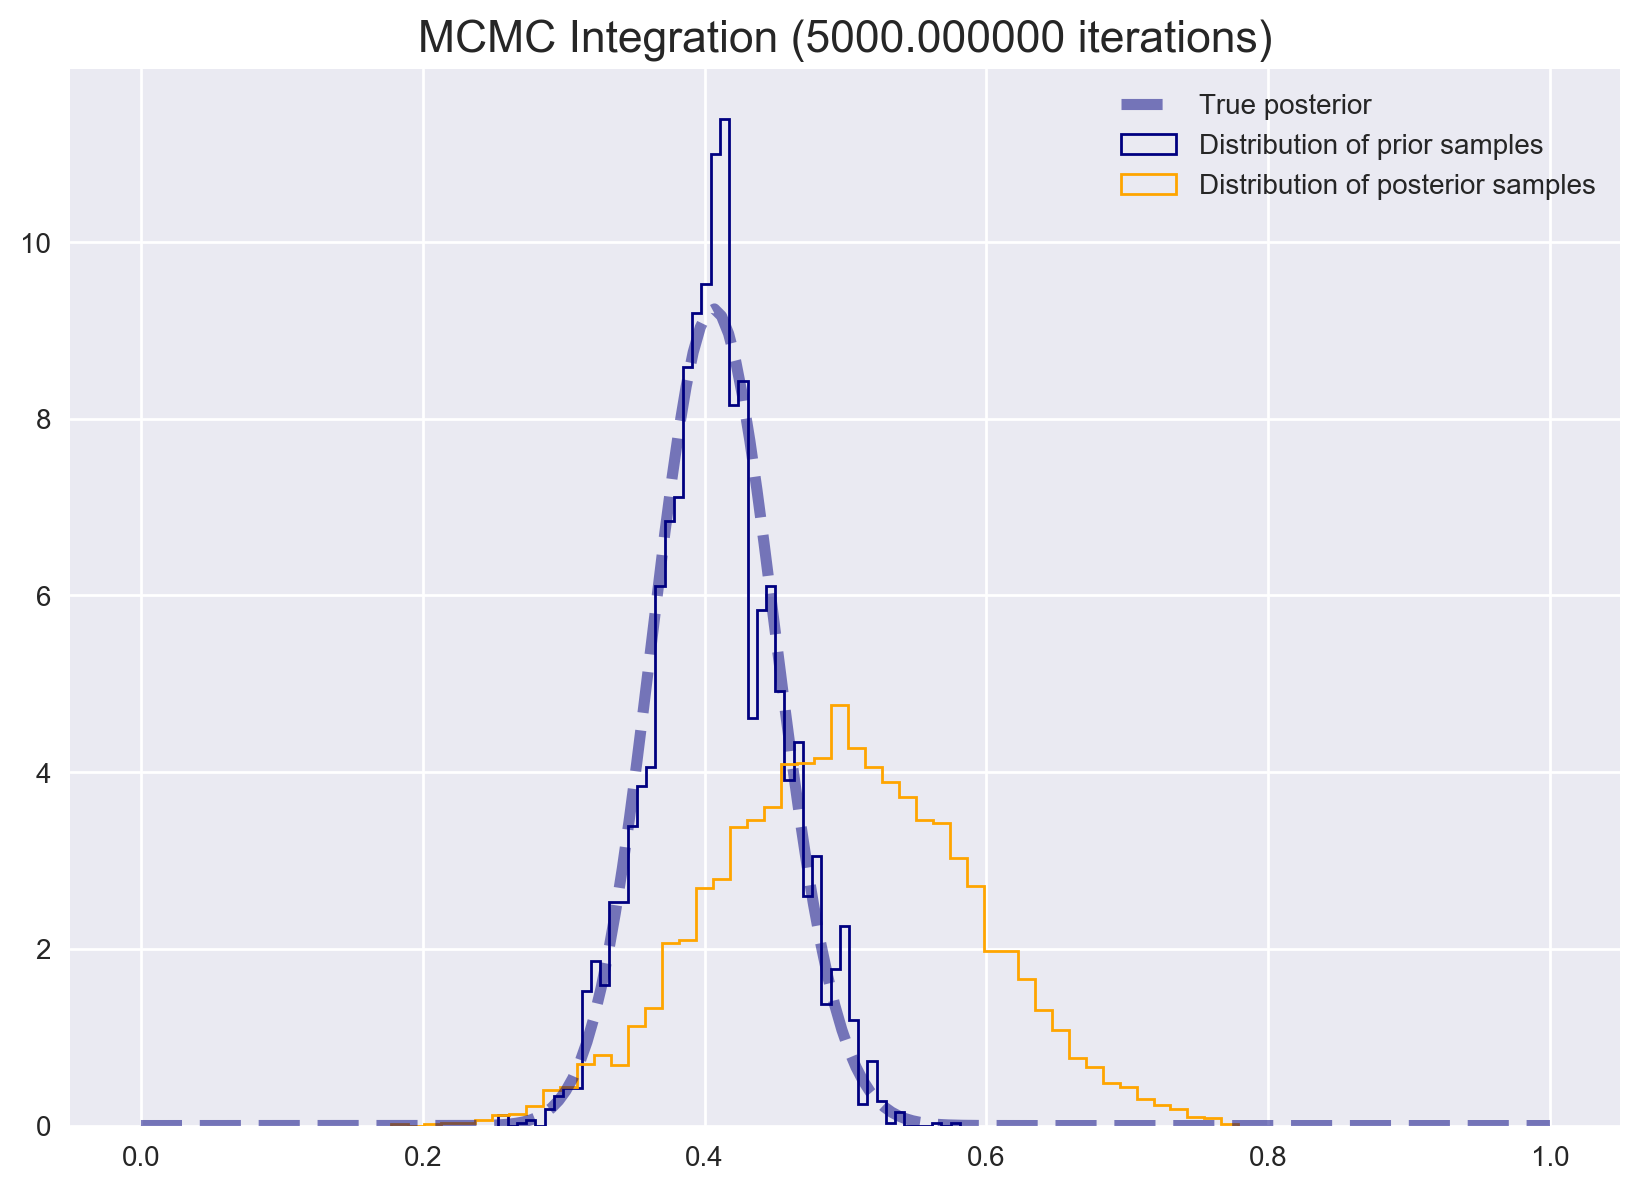

In [245]:
dist_posterior = st.beta(s+a, n-s+b)
thetas = np.linspace(0, 1, 200)

#plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':200})
#plt.title("MCMC Iteration Convergance Example", fontsize=16)
plt.rcParams.update({'figure.figsize':(10,7), 'figure.dpi':200})

plt.title("MCMC Integration (%f iterations)" % int(results_mcmc_10000[0]), fontsize=16)
plt.plot(thetas, dist_posterior.pdf(thetas), c='Navy', linestyle='--',linewidth=4, alpha=0.5, label='True posterior')
plt.hist(results_mcmc_10000[2][results_mcmc_10000[0]:], 50, histtype='step', density=True, color='Navy', linewidth=1, label='Distribution of prior samples')
plt.hist(dist_prior.rvs(results_mcmc_10000[0]), 50, histtype='step', density=True, color='Orange', linewidth=1, label='Distribution of posterior samples')

plt.legend()